In [2]:
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot
import cam
import ECGplot
import ECGHandle
import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd
from tqdm import tqdm

import time
import math
import os
import gc
from torch.utils.tensorboard import SummaryWriter


def seed_torch(seed=2023):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False 
	torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.enabled = False

In [3]:
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = "cpu"

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_torch(2023)

In [4]:
data_root = '/workspace/data/Preprocess_HTN/datas_/'
ALL_data = pd.read_csv(data_root+'/All_data_handled_ID_range_age_IDimputate.csv',low_memory=False)
ALL_data = ECGHandle.change_label(ALL_data)
ALL_data = ECGHandle.filter_ID(ALL_data)
ALL_data = ECGHandle.filter_QC(ALL_data)
ALL_data = ECGHandle.filter_ages(ALL_data,18)
ALL_data = ECGHandle.filter_departmentORlabel(ALL_data,'外科')
ALL_data = ECGHandle.correct_label(ALL_data)
ALL_data = ECGHandle.correct_age(ALL_data)
ALL_data = ECGHandle.filter_diagnose(ALL_data,'起搏')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'房颤')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左束支传导阻滞')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左前分支阻滞')
# ALL_data = ECGHandle.filter_diagnose(ALL_data,'阻滞')
# ALL_data = ECGHandle.remove_duplicated(ALL_data)
ALL_data = ALL_data.rename(columns={'住院号':'ID','年龄':'age','性别':'gender','姓名':'name'}) 
ALL_data_buffer = ALL_data.copy()
seed_torch(2023)
ALL_data_buffer = ALL_data_buffer.sample(frac=1).reset_index(drop=True) #打乱顺序
# all_dataset = ECGHandle.ECG_Dataset(data_root,ALL_data_buffer,preprocess = True)
####################################################################随机选取test
test_df,tv_df = Pair_ID(ALL_data,0.2,Range_max=15,pair_num=1)
test_dataset = ECGHandle.ECG_Dataset(data_root,test_df,preprocess = True)


Models_path = 'model/20230302_080241/20230302_080241/parameter_EarlyStoping_3.pt'
save_root = Models_path[:-3]+'/'
layervalue_root = save_root+'/layervalue/'





            orginal   removed diagnose NaN
   nums      200082          199997       
              HTN             NHTN        
   nums       3273           196724       


            orginal      removed ID NaN   
   nums      199997          199995       
              HTN             NHTN        
   nums       3273           196722       


            orginal            QC         
   nums      199995          72845        
              HTN             NHTN        
   nums       1497           71348        


            orginal      filtered ages    
   nums      72845           69819        
              HTN             NHTN        
   nums       1477           68342        


            orginal   filtered department 
   nums      69819           15344        
              HTN             NHTN        
   nums       1477           13867        


     reset num:       10  
  ERR labels num:     27  
            orginal      correct label    
   nums      15344           15

In [50]:
Models_path = '/workspace/data/Interpretable_HTN/model/20230307_144157/20230307_144157/BestF1_0.pt'
NET = [Net.MLBFNet_GUR_o(True,True,True,2,Dropout_rate=0.3), ] # type: ignore
criterion = torch.nn.CrossEntropyLoss()
testmodel = NET[0].to(DEVICE)
testmodel.load_state_dict(torch.load(Models_path))
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)  
y_true,y_pred,y_out,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 验证模型

In [5]:
def calculate_area(ECG:np.array,start_index:np.array,end_index:np.array): # type: ignore 
    p_area = 0
    for lead in range(12):
        for bet in range(len(start_index)):
            p_area = p_area + ((abs(ECG[lead,int(start_index[bet]):int(end_index[bet])] - ECG[lead].mean()).sum()))/(int(end_index[bet])-int(start_index[bet]))
    p_area = p_area/((len(start_index)))
    return p_area

In [47]:
waves_location_file_root = '/workspace/data/Preprocess_HTN/datas_/Wave/'

lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Amplitude_name_list = ['ECGFilename','label']
for i in range(12):
    Amplitude_name_list.append('PA_'+lead_index[i])
    Amplitude_name_list.append('QA_'+lead_index[i])
    Amplitude_name_list.append('RA_'+lead_index[i])
    Amplitude_name_list.append('SA_'+lead_index[i])
    Amplitude_name_list.append('TA_'+lead_index[i])
Amplitude_features_12leads =    pd.DataFrame(columns=Amplitude_name_list)
Timing_features = pd.DataFrame(columns=['ECGFilename','lable','P_wave_duration', 'QRS_duration', 'T_wave_duration','PQ_interval', 'PR_interval', 'QT_interval', 'QTc_interval', 'RR_interval','P_area'])

for index in range(1):#test_dataset.__len__()
    info =test_dataset.infos.iloc[index]
    ECG,_ = test_dataset.__getitem__(index)
    ECGfile_name = info['ECGFilename']
    layervalue_file = layervalue_root  + ECGfile_name +'.npy'
    
    FPT = np.load(waves_location_file_root+'/FPT/'+ECGfile_name+'.npy')
    Timing_feature_sync = np.load(waves_location_file_root+'/Timing_feature_sync/'+ECGfile_name+'.npy')
    Amplitude_feature_12leads = np.load(waves_location_file_root+'/Amplitude_feature_12leads/'+ECGfile_name+'.npy')
    
    Amplitude_feature_12leads = pd.DataFrame((Amplitude_feature_12leads.transpose(1,0,2)[1:-1]).reshape(-1,60),columns=Amplitude_name_list[2:]) #lead,bet,5 -> bet,lead,5 ->bet,lead*5 
    FPT = pd.DataFrame(FPT[1:-1],columns=['P_start', 'P_peak', 'P_end','Q_start', 'Q_peak', 'R_peak', 'S_peak', 'S_end','res0','T_start', 'T_peak', 'T_end','res0'])
    Timing_feature_sync = pd.DataFrame(Timing_feature_sync[1:-1],columns=['P_wave_duration', 'QRS_duration', 'T_wave_duration','PQ_interval', 'PR_interval', 'QT_interval', 'QTc_interval', 'RR_interval'])
    
    Timing_feature = Timing_feature_sync.mean()
    Timing_feature['ECGFilename'] = ECGfile_name
    Timing_feature['label'] = info['label']
    Timing_feature['P_area'] = calculate_area(np.array(ECG),np.array(FPT['P_start']),np.array(FPT['P_end']))
    Timing_feature['P_wave_duration'] = Timing_feature['P_wave_duration']/Timing_feature['RR_interval']
    Timing_feature['QRS_duration'] = Timing_feature['QRS_duration']/Timing_feature['RR_interval']
    Timing_feature['T_wave_duration'] = Timing_feature['T_wave_duration']/Timing_feature['RR_interval']
    Timing_feature['PQ_interval'] = Timing_feature['PQ_interval']/Timing_feature['RR_interval']
    Timing_feature['PR_interval'] = Timing_feature['PR_interval']/Timing_feature['RR_interval']
    Timing_feature['QT_interval'] = Timing_feature['QT_interval']/Timing_feature['RR_interval']
    Timing_feature['QTc_interval'] = Timing_feature['QTc_interval']/Timing_feature['RR_interval']
    
    Amplitude_feature = Amplitude_feature_12leads.mean()
    Amplitude_feature['ECGFilename'] = ECGfile_name
    Amplitude_feature['label'] = info['label']
    
    Amplitude_features_12leads = Amplitude_features_12leads.append(Amplitude_feature,True)
    Timing_features = Timing_features.append(Timing_feature,True )

In [48]:
Amplitude_features_12leads

,ECGFilename,label,PA_I,QA_I,RA_I,SA_I,TA_I,PA_II,QA_II,RA_II,...,PA_V5,QA_V5,RA_V5,SA_V5,TA_V5,PA_V6,QA_V6,RA_V6,SA_V6,TA_V6
0,20-43338,1,76.172728,-94.93503,997.358283,-94.655365,177.971277,114.653776,-49.458277,356.053569,...,73.887575,-31.002564,920.863129,-593.302143,60.564153,75.116707,-33.71792,686.005756,-314.33106,70.479815


In [41]:
(Amplitude_feature_12leads.transpose(1,0,2))[1:-1][0] #lead,bet,5 -> bet,lead,5 ->bet,lead*5 

array([[   61.30010584,   -93.23219137,   938.83011248,  -119.98874407,
          180.30836488],
       [  107.51269255,   -56.57941622,   337.86957895,    17.48501671,
          116.37480342],
       [   59.94523862,    83.9490308 ,  -602.67374355,   172.23572074,
           18.83671687],
       [  -78.71316344,    71.81358097,  -633.3028308 ,    45.83268898,
         -143.87423464],
       [    5.68412182,   -82.56200567,   771.2512749 ,  -139.78282108,
          123.59770591],
       [   79.06170359,    80.90462528,  -127.99370143,   138.84359493,
           31.72646821],
       [   54.70991082,   173.18357099,  -647.97213104,    24.74415517,
           10.86093843],
       [   74.11938115,   541.02114441, -1130.12510344,    22.797839  ,
          146.43162274],
       [   70.59589236,   612.72294417,  -911.77200328,     5.83315214,
           94.96997316],
       [   60.30776472,   799.06608751,  -699.71420164,   -34.7718722 ,
           58.80519677],
       [   78.352848  ,   -31.

In [42]:
(Amplitude_feature_12leads.transpose(1,0,2))[1:-1].reshape(-1,60) #lead,bet,5 -> bet,lead,5 ->bet,lead*5 

array([   61.30010584,   -93.23219137,   938.83011248,  -119.98874407,
         180.30836488,   107.51269255,   -56.57941622,   337.86957895,
          17.48501671,   116.37480342,    59.94523862,    83.9490308 ,
        -602.67374355,   172.23572074,    18.83671687,   -78.71316344,
          71.81358097,  -633.3028308 ,    45.83268898,  -143.87423464,
           5.68412182,   -82.56200567,   771.2512749 ,  -139.78282108,
         123.59770591,    79.06170359,    80.90462528,  -127.99370143,
         138.84359493,    31.72646821,    54.70991082,   173.18357099,
        -647.97213104,    24.74415517,    10.86093843,    74.11938115,
         541.02114441, -1130.12510344,    22.797839  ,   146.43162274,
          70.59589236,   612.72294417,  -911.77200328,     5.83315214,
          94.96997316,    60.30776472,   799.06608751,  -699.71420164,
         -34.7718722 ,    58.80519677,    78.352848  ,   -31.67566541,
         950.80615349,  -587.32744623,    67.48426302,    81.74517879,
      

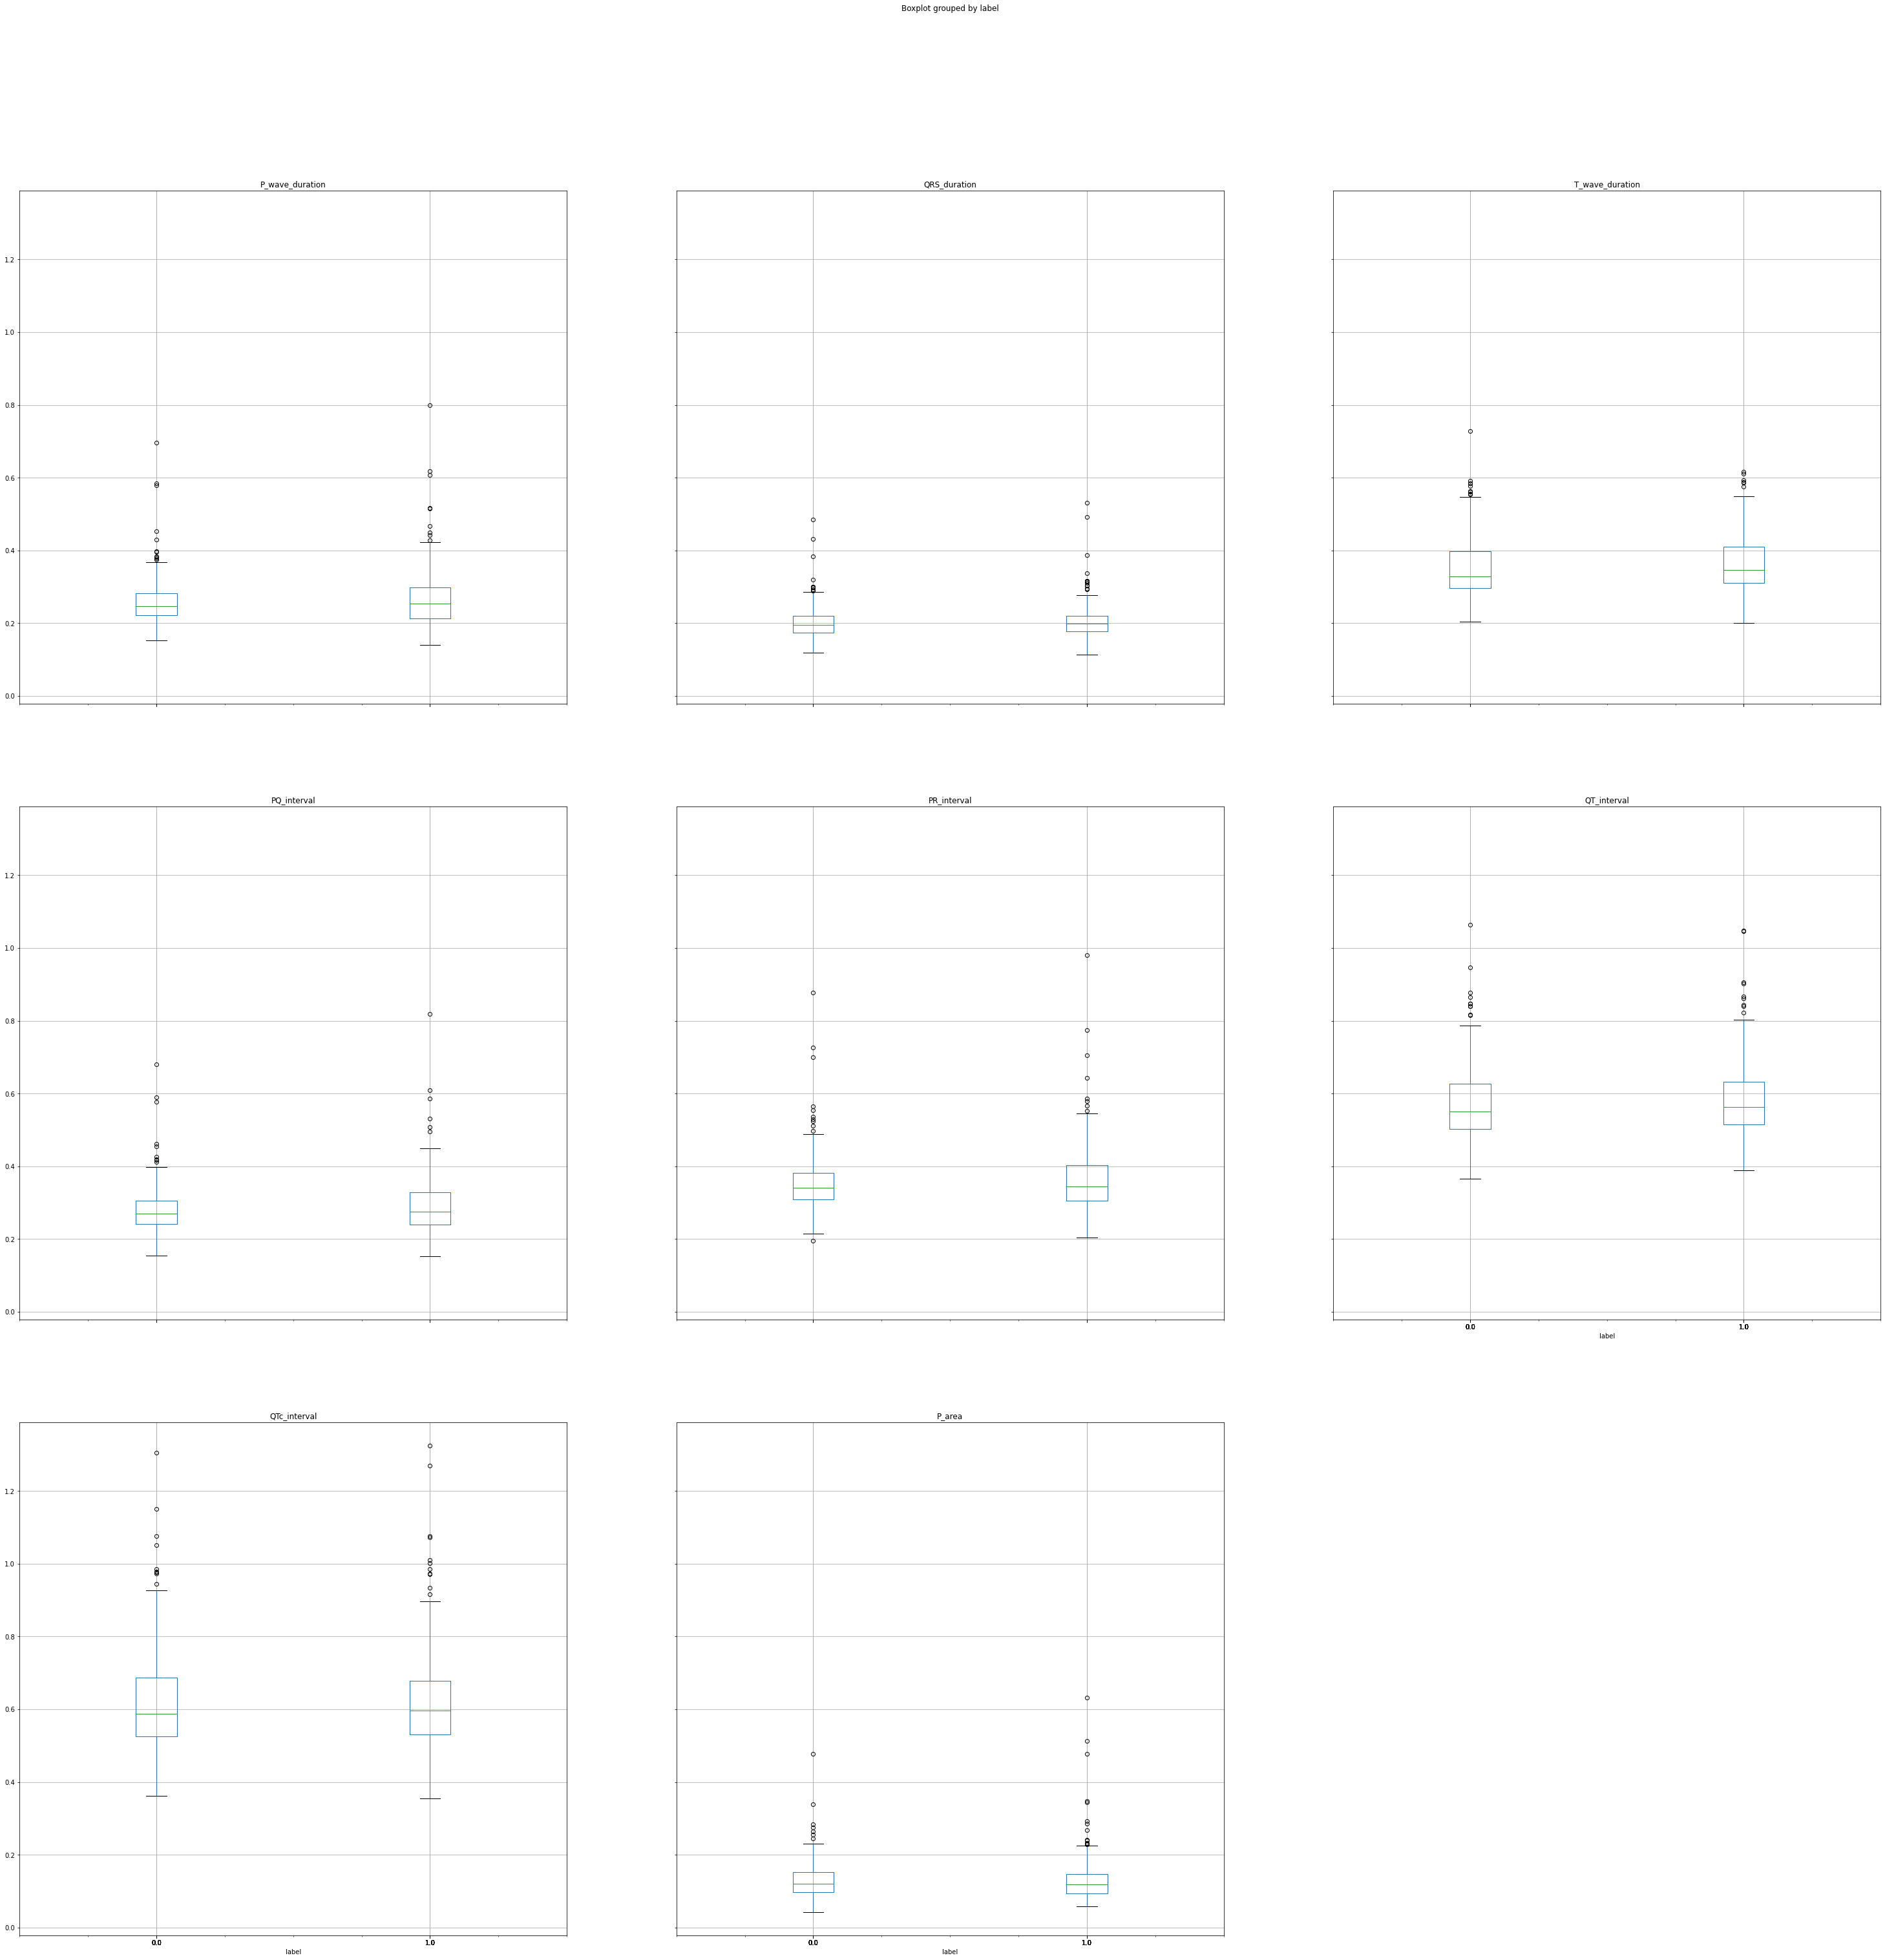

In [224]:
boxplot = Timing_features.boxplot(column=['P_wave_duration', 'QRS_duration', 'T_wave_duration','PQ_interval', 'PR_interval', 'QT_interval', 'QTc_interval','P_area'],by='label',figsize=(50,50))

In [ ]:
Timing_features